In [1]:
!pip install split-folders

### **Importing of Necessary Libraries**

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2
import os
import PIL
import pathlib
import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
import wandb
from wandb.keras import WandbCallback
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wandb_api") 
wandb.login(key=wandb_api)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### **Dataset Loading and Splitting**
Split-folders library was used to split the dataset into three parts: Training set(60%), Validation set(20%), and Test set(20%).

In [4]:
base_ds = '/kaggle/input/rosenet/Original Dataset'
base_ds = pathlib.Path(base_ds)

In [5]:
splitfolders.ratio(base_ds, output='imgs', seed=123, ratio=(.6,.2,.2), group_prefix=None)

Copying files: 917 files [00:12, 76.09 files/s]


In [6]:
Blackspot= [fn for fn in os.listdir(f'{base_ds}/Black Spot') if (fn.endswith('.jpg') or fn.endswith('.jpeg'))]
DownyMildew= [fn for fn in os.listdir(f'{base_ds}/Downy Mildew') if (fn.endswith('.jpg') or fn.endswith('.jpeg'))]
FreshLeaf= [fn for fn in os.listdir(f'{base_ds}/Fresh Leaf') if (fn.endswith('.jpg') or fn.endswith('.jpeg'))]
#Die_Back= [fn for fn in os.listdir(f'{base_ds}/Die Back') if (fn.endswith('.jpg') or fn.endswith('.jpeg'))]
#Gall_Midge= [fn for fn in os.listdir(f'{base_ds}/Gall Midge') if (fn.endswith('.jpg') or fn.endswith('.jpeg'))]
#Healthy= [fn for fn in os.listdir(f'{base_ds}/Healthy') if (fn.endswith('.jpg') or fn.endswith('.jpeg'))]
#Powdery_Mildew= [fn for fn in os.listdir(f'{base_ds}/Powdery Mildew') if (fn.endswith('.jpg') or fn.endswith('.jpeg'))]
#Sooty_Mould= [fn for fn in os.listdir(f'{base_ds}/Sooty Mould') if (fn.endswith('.jpg') or fn.endswith('.jpeg'))]


coffee= [Blackspot, DownyMildew, FreshLeaf]
coffee_classes = []
for i in os.listdir('imgs/train'):
    coffee_classes+=[i]
coffee_classes.sort()



### **Dataset Exploration**
It can be seen here the total number of images in the dataset, the number of classes, and how well the images from each variety is distributed

Total images: 917
Total number of classes: 3
Total Black Spot images: 313
Total Downy Mildew images: 200
Total Fresh Leaf images: 404


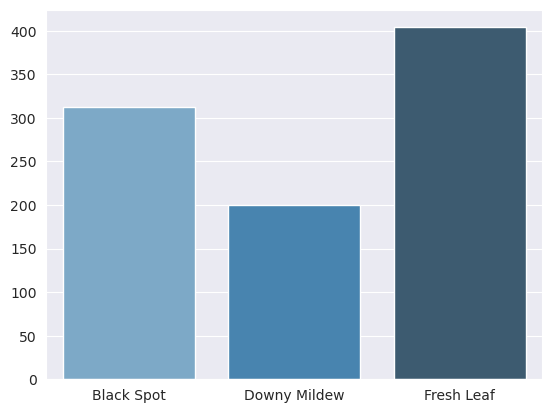

In [7]:
image_count1= len(list(base_ds.glob('*/*.jpg')))
image_count2 = len(list(base_ds.glob('*/*.jpeg')))
image_count=image_count1+image_count2
print(f'Total images: {image_count}')
print(f'Total number of classes: {len(coffee_classes)}')
count = 0
coffee_count = []
for x in coffee_classes:
  print(f'Total {x} images: {len(coffee[count])}')
  coffee_count.append(len(coffee[count]))
  count+=1

sns.set_style('darkgrid')
sns.barplot(x=coffee_classes, y=coffee_count, palette="Blues_d")
plt.show()

### Sample Images
Each image from the dataset has a dimension of 250 by 250 and a color type of RGB

Image dimensions: (1396, 1109, 3)


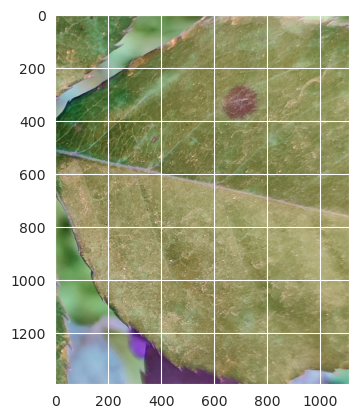

In [8]:
sample_img = cv2.imread('/kaggle/input/rosenet/Original Dataset/Black Spot/Black Spot (1).jpg')
plt.imshow(sample_img)
print(f'Image dimensions: {sample_img.shape}')

In [9]:
def load_random_img(dir, label):
  plt.figure(figsize=(10,10))
  i=0
  for label in coffee_classes:
    i+=1
    plt.subplot(1,8, i)
    file = random.choice(os.listdir(f'{dir}/{label}'))
    image_path = os.path.join(f'{dir}/{label}', file)
    img=cv2.imread(image_path)
    plt.title(label)
    plt.imshow(img)
    plt.grid(None)
    plt.axis('off')

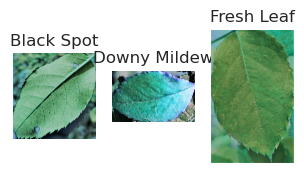

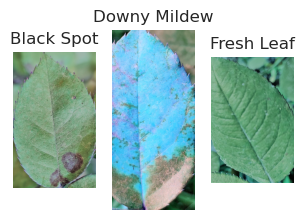

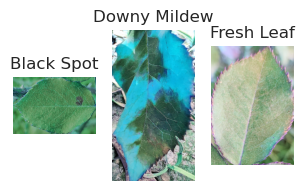

In [10]:
for i in range(3):
  load_random_img(base_ds,coffee_classes)

In [11]:
batch_size =16
img_height, img_width =128,128
input_shape = (img_height, img_width, 3)

CONFIG=dict(
            batch_size =16,
            img_height=128,
            img_width =128,
            )

### **Data Pre-processing**

In [12]:
train_datagen = ImageDataGenerator(rescale=1./255,
                               rotation_range=30,
                               zoom_range=0.15,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.15,
                               horizontal_flip=True,
                               fill_mode="nearest")

test_datagen=ImageDataGenerator(rescale=1./255)

In [13]:
train_ds = train_datagen.flow_from_directory(
    'imgs/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    subset = "training",
    class_mode='categorical',
    shuffle=True
    )

val_ds = train_datagen.flow_from_directory(
    'imgs/val',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

test_ds = test_datagen.flow_from_directory(
    'imgs/test',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

Found 549 images belonging to 3 classes.
Found 182 images belonging to 3 classes.
Found 186 images belonging to 3 classes.


In [14]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

CONFIG['model_name'] = 'InceptionV3'
print('Training configuration: ', CONFIG)

# Initialize W&B run
run = wandb.init(settings=wandb.Settings(start_method="fork"),
                 reinit=True,
                 project='Rose',
                 entity="sanjeevsharma22",
                 config=CONFIG,
                 group='InceptionV3', 
                 job_type='train')

wandb.config.type = 'baseline'

In [15]:
CONFIG['model_name'] = 'InceptionV3'
print('Training configuration: ', CONFIG)

# Initialize W&B run
run = wandb.init(settings=wandb.Settings(start_method="fork"),
                 reinit=True,
                 project='Rose',
                 entity="sanjeevsharma22",
                 config=CONFIG,
                 group='InceptionV3', 
                 job_type='train')

wandb.config.type = 'baseline'

Training configuration:  {'batch_size': 16, 'img_height': 128, 'img_width': 128, 'model_name': 'InceptionV3'}


wandb: Currently logged in as: sanjeevsharma22. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.15.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20230606_070922-d929coei
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run swept-monkey-28
wandb: ⭐️ View project at https://wandb.ai/sanjeevsharma22/Rose
wandb: 🚀 View run at https://wandb.ai/sanjeevsharma22/Rose/runs/d929coei


## **Transfer Learning**

In [16]:
model=tf.keras.applications.InceptionV3(weights="imagenet", include_top=False, input_shape=input_shape)
model.trainable = True
inputs = tf.keras.Input(input_shape)
x = model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)
model= tf.keras.Model(inputs, x)

87910968/87910968 [==============================] - 3s 0us/step


In [17]:
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 3)                 3075      
                                                                 
Total params: 23,904,035
Trainable params: 23,869,603
Non-trainable params: 34,432
____________________________________________

## **Fine Tuning**

In [18]:
history3 =model.fit(train_ds, epochs =30, validation_data = val_ds,callbacks=[WandbCallback()])
run.finish()

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/30
35/35 [==============================] - ETA: 0s - loss: 1.0099 - accuracy: 0.5392

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230606_070922-d929coei/files/model-best)... Done. 1.2s


35/35 [==============================] - 108s 2s/step - loss: 1.0099 - accuracy: 0.5392 - val_loss: 0.7619 - val_accuracy: 0.7033
Epoch 2/30
35/35 [==============================] - ETA: 0s - loss: 0.6117 - accuracy: 0.7341

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230606_070922-d929coei/files/model-best)... Done. 1.4s


35/35 [==============================] - 60s 2s/step - loss: 0.6117 - accuracy: 0.7341 - val_loss: 0.4322 - val_accuracy: 0.8132
Epoch 3/30
35/35 [==============================] - ETA: 0s - loss: 0.4245 - accuracy: 0.8397

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230606_070922-d929coei/files/model-best)... Done. 1.2s


35/35 [==============================] - 62s 2s/step - loss: 0.4245 - accuracy: 0.8397 - val_loss: 0.4273 - val_accuracy: 0.8571
Epoch 4/30
35/35 [==============================] - ETA: 0s - loss: 0.2997 - accuracy: 0.8871

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230606_070922-d929coei/files/model-best)... Done. 1.3s


35/35 [==============================] - 64s 2s/step - loss: 0.2997 - accuracy: 0.8871 - val_loss: 0.3406 - val_accuracy: 0.8626
Epoch 5/30
35/35 [==============================] - ETA: 0s - loss: 0.2529 - accuracy: 0.8944

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230606_070922-d929coei/files/model-best)... Done. 1.3s


35/35 [==============================] - 63s 2s/step - loss: 0.2529 - accuracy: 0.8944 - val_loss: 0.2254 - val_accuracy: 0.9011
Epoch 6/30
35/35 [==============================] - ETA: 0s - loss: 0.2029 - accuracy: 0.9217

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230606_070922-d929coei/files/model-best)... Done. 1.3s


35/35 [==============================] - 63s 2s/step - loss: 0.2029 - accuracy: 0.9217 - val_loss: 0.2156 - val_accuracy: 0.9121
Epoch 7/30
35/35 [==============================] - ETA: 0s - loss: 0.2165 - accuracy: 0.9144

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230606_070922-d929coei/files/model-best)... Done. 1.3s


35/35 [==============================] - 62s 2s/step - loss: 0.2165 - accuracy: 0.9144 - val_loss: 0.1933 - val_accuracy: 0.9286
Epoch 8/30
35/35 [==============================] - ETA: 0s - loss: 0.1520 - accuracy: 0.9435

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230606_070922-d929coei/files/model-best)... Done. 1.3s


35/35 [==============================] - 60s 2s/step - loss: 0.1520 - accuracy: 0.9435 - val_loss: 0.1868 - val_accuracy: 0.9341
Epoch 9/30
35/35 [==============================] - 14s 415ms/step - loss: 0.1870 - accuracy: 0.9326 - val_loss: 0.2380 - val_accuracy: 0.9176
Epoch 10/30
35/35 [==============================] - ETA: 0s - loss: 0.1484 - accuracy: 0.9490

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230606_070922-d929coei/files/model-best)... Done. 1.2s


35/35 [==============================] - 59s 2s/step - loss: 0.1484 - accuracy: 0.9490 - val_loss: 0.1556 - val_accuracy: 0.9286
Epoch 11/30
35/35 [==============================] - 15s 425ms/step - loss: 0.1196 - accuracy: 0.9435 - val_loss: 0.2194 - val_accuracy: 0.9231
Epoch 12/30
35/35 [==============================] - ETA: 0s - loss: 0.1292 - accuracy: 0.9472

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230606_070922-d929coei/files/model-best)... Done. 1.1s


35/35 [==============================] - 58s 2s/step - loss: 0.1292 - accuracy: 0.9472 - val_loss: 0.1181 - val_accuracy: 0.9615
Epoch 13/30
35/35 [==============================] - ETA: 0s - loss: 0.1207 - accuracy: 0.9545

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230606_070922-d929coei/files/model-best)... Done. 1.2s


35/35 [==============================] - 62s 2s/step - loss: 0.1207 - accuracy: 0.9545 - val_loss: 0.0844 - val_accuracy: 0.9615
Epoch 14/30
35/35 [==============================] - 15s 430ms/step - loss: 0.1132 - accuracy: 0.9636 - val_loss: 0.1091 - val_accuracy: 0.9725
Epoch 15/30
35/35 [==============================] - 13s 373ms/step - loss: 0.1003 - accuracy: 0.9709 - val_loss: 0.1624 - val_accuracy: 0.9341
Epoch 16/30
35/35 [==============================] - 14s 409ms/step - loss: 0.0879 - accuracy: 0.9654 - val_loss: 0.1745 - val_accuracy: 0.9505
Epoch 17/30
35/35 [==============================] - 13s 383ms/step - loss: 0.0555 - accuracy: 0.9800 - val_loss: 0.1158 - val_accuracy: 0.9615
Epoch 18/30
35/35 [==============================] - 13s 378ms/step - loss: 0.0998 - accuracy: 0.9672 - val_loss: 0.1436 - val_accuracy: 0.9451
Epoch 19/30
35/35 [==============================] - 14s 394ms/step - loss: 0.0889 - accuracy: 0.9763 - val_loss: 0.1406 - val_accuracy: 0.9615
Epoch 2

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230606_070922-d929coei/files/model-best)... Done. 1.2s


35/35 [==============================] - 59s 2s/step - loss: 0.0430 - accuracy: 0.9872 - val_loss: 0.0821 - val_accuracy: 0.9615
Epoch 26/30
35/35 [==============================] - 15s 418ms/step - loss: 0.0867 - accuracy: 0.9617 - val_loss: 0.0868 - val_accuracy: 0.9670
Epoch 27/30
35/35 [==============================] - 14s 400ms/step - loss: 0.0343 - accuracy: 0.9872 - val_loss: 0.1151 - val_accuracy: 0.9451
Epoch 28/30
35/35 [==============================] - ETA: 0s - loss: 0.0461 - accuracy: 0.9836

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230606_070922-d929coei/files/model-best)... Done. 1.2s


35/35 [==============================] - 59s 2s/step - loss: 0.0461 - accuracy: 0.9836 - val_loss: 0.0736 - val_accuracy: 0.9725
Epoch 29/30
35/35 [==============================] - 15s 420ms/step - loss: 0.0461 - accuracy: 0.9872 - val_loss: 0.1327 - val_accuracy: 0.9396
Epoch 30/30
35/35 [==============================] - 14s 390ms/step - loss: 0.0400 - accuracy: 0.9836 - val_loss: 0.1211 - val_accuracy: 0.9560


wandb: Waiting for W&B process to finish... (success).
wandb: 
wandb: Run history:
wandb:     accuracy ▁▄▆▆▇▇▇▇▇▇▇▇▇█████████████████
wandb:        epoch ▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
wandb:         loss █▅▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: val_accuracy ▁▄▅▅▆▆▇▇▇▇▇███▇▇█▇█▇▇██▇██▇█▇█
wandb:     val_loss █▅▅▄▃▂▂▂▃▂▂▁▁▁▂▂▁▂▂▂▂▁▂▄▁▁▁▁▂▁
wandb: 
wandb: Run summary:
wandb:      accuracy 0.98361
wandb:    best_epoch 27
wandb: best_val_loss 0.0736
wandb:         epoch 29
wandb:          loss 0.03996
wandb:  val_accuracy 0.95604
wandb:      val_loss 0.1211
wandb: 
wandb: 🚀 View run swept-monkey-28 at: https://wandb.ai/sanjeevsharma22/Rose/runs/d929coei
wandb: Synced 6 W&B file(s), 1 media file(s), 65 artifact file(s) and 1 other file(s)
wandb: Find logs at: ./wandb/run-20230606_070922-d929coei/logs


## **Final Evaluation**

In [19]:
run = wandb.init(settings=wandb.Settings(start_method="fork"),
                 reinit=True,
                 project='Rose', 
                 config=CONFIG,
                 group='InceptionV3', 
                 job_type='evaluate') # Note the job_type

# Update `wandb.config`
wandb.config.type = 'baseline'

# Evaluate model
score3 =model.evaluate(test_ds, verbose=1)

# Finish the run
run.finish()

wandb: Tracking run with wandb version 0.15.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20230606_072830-pzsuleqv
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run effortless-totem-30
wandb: ⭐️ View project at https://wandb.ai/sanjeevsharma22/Rose
wandb: 🚀 View run at https://wandb.ai/sanjeevsharma22/Rose/runs/pzsuleqv


12/12 [==============================] - 5s 438ms/step - loss: 0.0240 - accuracy: 0.9892


wandb: Waiting for W&B process to finish... (success).
wandb: 🚀 View run effortless-totem-30 at: https://wandb.ai/sanjeevsharma22/Rose/runs/pzsuleqv
wandb: Synced 6 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20230606_072830-pzsuleqv/logs


In [20]:
print(f'Pretrained Network Fine-tuned "\n"Loss: {score3[0]},"\n" Accuracy: {score3[1]*100}')

Pretrained Network Fine-tuned "
"Loss: 0.023978056386113167,"
" Accuracy: 98.92473220825195


In [21]:
Y_pred =model.predict(test_ds)

12/12 [==============================] - 4s 206ms/step


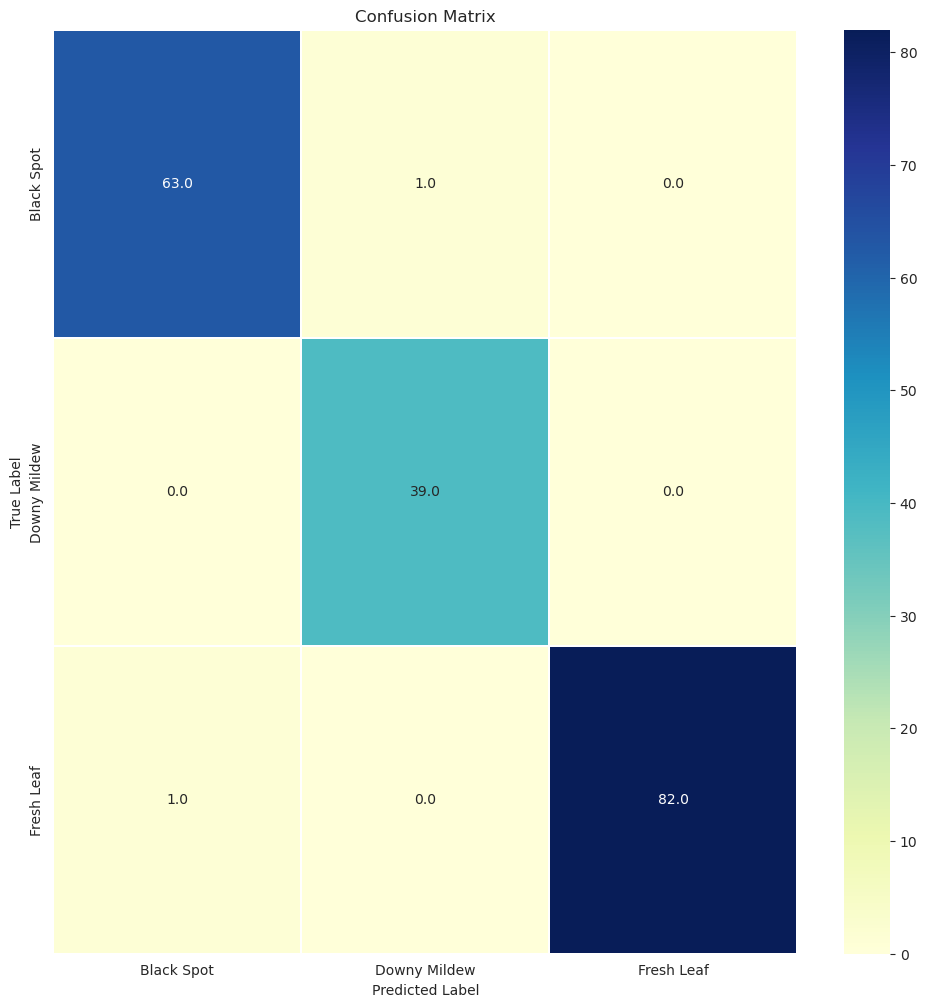

In [22]:
y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,
           cmap="YlGnBu",)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(coffee_classes)
plt.title("Confusion Matrix")
plt.show()

In [23]:
report2 = classification_report(test_ds.classes, y_pred, target_names=coffee_classes, output_dict=True)
df2 = pd.DataFrame(report2).transpose()
df2

,precision,recall,f1-score,support
Black Spot,0.984375,0.984375,0.984375,64.000000
Downy Mildew,1.000000,0.975000,0.987342,40.000000
Fresh Leaf,0.987952,1.000000,0.993939,82.000000
accuracy,0.989247,0.989247,0.989247,0.989247
macro avg,0.990776,0.986458,0.988552,186.000000
weighted avg,0.989312,0.989247,0.989230,186.000000


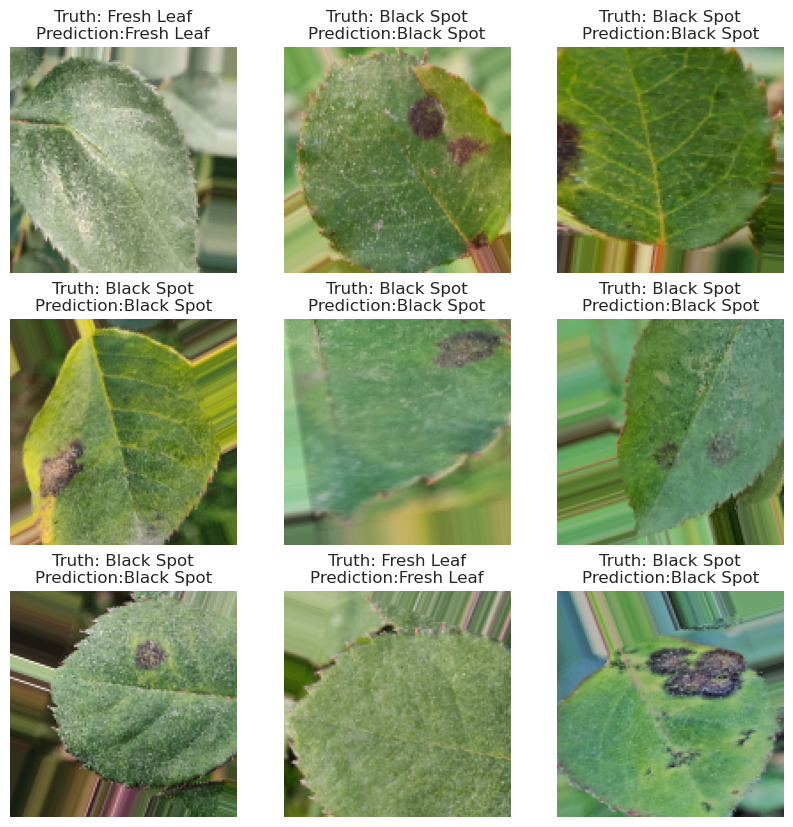

In [24]:
plt.figure(figsize=(10, 10))
x, label= train_ds.next()
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x[i])
    result = np.where(label[i]==1)
    predict =model(tf.expand_dims(x[i], 0))
    score = tf.nn.softmax(predict[0])
    score_label =coffee_classes[np.argmax(score)]
    plt.title(f'Truth: {coffee_classes[result[0][0]]}\nPrediction:{score_label}')
    plt.axis(False)

In [25]:
model.save('InceptionV3-baseline.h5')

# Initialize a new W&B run
run = wandb.init(settings=wandb.Settings(start_method="fork"),
                 reinit=True,
                 project='Rose', 
                 config=CONFIG,
                 group='InceptionV3', 
                 job_type='save') # Note the job_type

# Update `wandb.config`
wandb.config.type = 'baseline'

# Save model as Model Artifact
artifact = wandb.Artifact(name='InceptionV3', type='model')
artifact.add_file('InceptionV3-baseline.h5')
run.log_artifact(artifact)

# Finish W&B run
run.finish()

wandb: Tracking run with wandb version 0.15.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20230606_072939-a7y6umma
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run expert-durian-31
wandb: ⭐️ View project at https://wandb.ai/sanjeevsharma22/Rose
wandb: 🚀 View run at https://wandb.ai/sanjeevsharma22/Rose/runs/a7y6umma
wandb: Waiting for W&B process to finish... (success).
wandb: 🚀 View run expert-durian-31 at: https://wandb.ai/sanjeevsharma22/Rose/runs/a7y6umma
wandb: Synced 5 W&B file(s), 0 media file(s), 1 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20230606_072939-a7y6umma/logs


<h2>Support by giving an upvote!!</h2>